<a href="https://colab.research.google.com/github/butter-my-toast/TrafficCollisionML/blob/main/collision_severity_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab.data_table import DataTable
DataTable.max_columns = 75

In [ ]:
# kaggle api key
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alexgude/california-traffic-collision-data-from-switrs
! unzip -q california-traffic-collision-data-from-switrs.zip

Saving kaggle.json to kaggle.json
100% 1.50G/1.50G [00:19<00:00, 129MB/s]
100% 1.50G/1.50G [00:19<00:00, 82.9MB/s]


In [ ]:
cnx = sqlite3.connect('/content/switrs.sqlite')
cursor = cnx.cursor()

In [ ]:
QUERY = """
SELECT * FROM parties LIMIT 50
"""
QUERY2 = """
SELECT * FROM victims LIMIT 50
"""
QUERY3 = """
SELECT collision_severity, collision_date FROM collisions
"""
QUERY4 = """
SELECT collision_severity, COUNT(*) as count FROM collisions GROUP BY collision_severity
"""
QUERY5 = """
SELECT state_highway_indicator, COUNT(*) as count FROM collisions GROUP BY state_highway_indicator
"""
QUERY6 = """
SELECT longitude, latitude FROM collisions
WHERE collision_severity LIKE "fatal"
"""
COLUMN_NAMES_QUERY = """
PRAGMA table_info(collisions)
"""
FINAL_QUERY1 = """
SELECT longitude, latitude, lighting, weather_1, weather_2, collision_time, alcohol_involved, collision_severity FROM collisions
"""

FINAL_QUERY2 = """
SELECT c.longitude, c.latitude, c.lighting, c.road_surface, c.state_highway_indicator, c.weather_1, c.weather_2, c.collision_time, c.collision_severity, c.collision_date, p.party_age, p.party_sex
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.at_fault = 1;
"""

FINAL_QUERY3 = """
SELECT c.longitude, c.latitude, c.intersection, c.road_surface, c.lighting, c.state_highway_indicator, c.weather_1, c.weather_2, c.collision_time, c.collision_severity, c.collision_date, p.party_age, p.party_sex
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.at_fault = 1;
"""


FINAL_QUERY4 = """
SELECT c.longitude, c.latitude, c.intersection, c.road_surface, c.lighting, c.state_highway_indicator, c.weather_1, c.weather_2, c.collision_time, c.collision_severity, c.collision_date
FROM collisions c
"""

FINAL_QUERY5 = """
SELECT c.collision_severity, p.party_race
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.at_fault = 1;
"""

# voting classifier

In [ ]:
cursor.execute(COLUMN_NAMES_QUERY)
column_names = [row[1] for row in cursor.fetchall()]
for column in column_names:
    print(column)

case_id
jurisdiction
officer_id
reporting_district
chp_shift
population
county_city_location
county_location
special_condition
beat_type
chp_beat_type
city_division_lapd
chp_beat_class
beat_number
primary_road
secondary_road
distance
direction
intersection
weather_1
weather_2
state_highway_indicator
caltrans_county
caltrans_district
state_route
route_suffix
postmile_prefix
postmile
location_type
ramp_intersection
side_of_highway
tow_away
collision_severity
killed_victims
injured_victims
party_count
primary_collision_factor
pcf_violation_code
pcf_violation_category
pcf_violation
pcf_violation_subsection
hit_and_run
type_of_collision
motor_vehicle_involved_with
pedestrian_action
road_surface
road_condition_1
road_condition_2
lighting
control_device
chp_road_type
pedestrian_collision
bicycle_collision
motorcycle_collision
truck_collision
not_private_property
alcohol_involved
statewide_vehicle_type_at_fault
chp_vehicle_type_at_fault
severe_injury_count
other_visible_injury_count
complaint_

In [ ]:
pd.read_sql(QUERY, cnx)

,id,case_id,party_number,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,...,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,statewide_vehicle_type,chp_vehicle_type_towing,chp_vehicle_type_towed,party_race
0,1,0081715,1,driver,1,female,35.0,not applicable,not applicable,north,...,None,0,0,proceeding straight,2007.0,ford,None,None,None,other
1,2,0081715,2,driver,0,female,43.0,not applicable,not applicable,north,...,None,0,0,proceeding straight,2019.0,None,None,None,None,hispanic
2,3,0726202,1,driver,1,None,NaN,impairment unknown,G,north,...,None,0,0,proceeding straight,2005.0,None,passenger car,"passenger car, station",None,None
3,4,3858022,1,driver,1,male,47.0,impairment unknown,G,east,...,None,0,0,None,2007.0,dodge,emergency vehicle,police car,00,black
4,5,3858022,2,driver,0,male,58.0,had not been drinking,None,east,...,None,0,0,None,2006.0,nissan,None,None,00,hispanic
5,6,3899441,1,driver,1,male,16.0,impairment unknown,G,south,...,None,0,0,proceeding straight,1994.0,toyota,passenger car,"passenger car, station",00,asian
6,7,3899442,1,driver,1,male,40.0,had not been drinking,None,south,...,None,0,0,proceeding straight,2001.0,toyota,passenger car,"passenger car, station",00,hispanic
7,8,3899442,2,driver,0,male,46.0,had not been drinking,None,south,...,None,0,0,proceeding straight,2003.0,toyota,passenger car,"passenger car, station",00,asian
8,9,3899445,1,driver,1,male,24.0,had not been drinking,None,north,...,None,0,0,other,1999.0,toyota,passenger car,"passenger car, station",00,hispanic
9,10,3899445,2,driver,0,female,32.0,had not been drinking,None,north,...,None,0,0,proceeding straight,2007.0,nissan,passenger car,"passenger car, station",00,asian


<ipython-input-92-b0cdb91e4a34>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = pd.to_datetime(filtered_df['collision_date']).dt.year


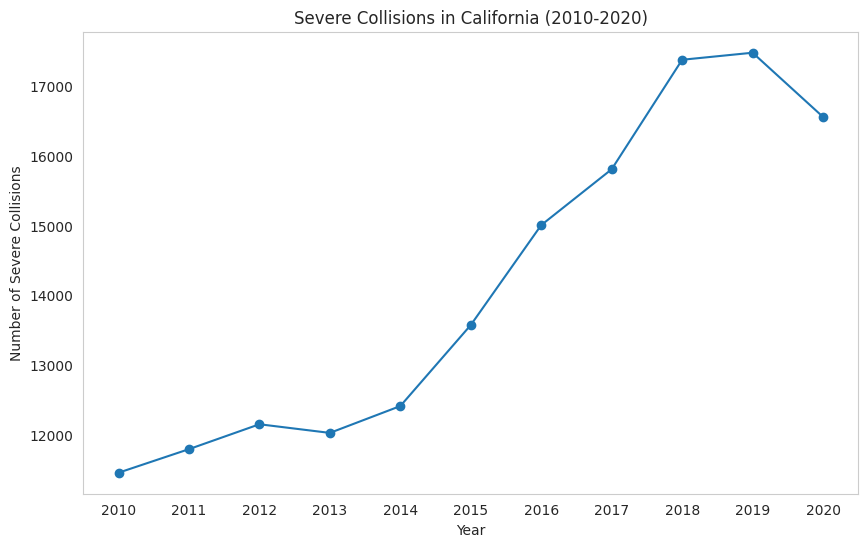

In [ ]:
filtered_df = overyear_df[(overyear_df['collision_severity'].isin(['severe injury', 'fatal'])) &
                          (overyear_df['collision_date'] >= '2010-01-01') &
                          (overyear_df['collision_date'] <= '2020-12-31')]

filtered_df['year'] = pd.to_datetime(filtered_df['collision_date']).dt.year


yearly_severe_collisions = filtered_df.groupby('year').size()


plt.figure(figsize=(10, 6))
plt.plot(yearly_severe_collisions.index, yearly_severe_collisions.values, marker='o')
plt.title('Severe Collisions in California (2010-2020)')
plt.xlabel('Year')
plt.ylabel('Number of Severe Collisions')
plt.xticks(yearly_severe_collisions.index)
plt.grid(False)
plt.show()

In [ ]:
pd.read_sql(QUERY4, cnx)
# motor_vehicle_involved_with

,collision_severity,count
0,N,1
1,fatal,66421
2,other injury,1163199
3,pain,2268304
4,property damage only,5704634
5,severe injury,221775


In [ ]:
pd.read_sql(QUERY5, cnx)
# motor_vehicle_involved_with

,state_highway_indicator,count
0,NaN,3324
1,0.0,5870709
2,1.0,3550301


In [ ]:
dqwij = pd.read_sql(FINAL_QUERY3, cnx)
dqwij['party_sex'].value_counts()

male      4928656
female    2706329
X            3517
Name: party_sex, dtype: int64

In [ ]:
print("hi")
df = pd.read_sql(FINAL_QUERY4, cnx)
# df = df.dropna(subset=['longitude', 'latitude', 'collision_severity', 'weather_1', 'lighting', 'collision_time'])
df = df.dropna(subset=['lighting', 'intersection', 'longitude', 'latitude', 'road_surface', 'state_highway_indicator', 'collision_date', 'collision_severity', 'weather_1', 'collision_time'])
df.drop(df[df['lighting'] == 'G'].index, inplace=True) # G was a typo by whoever made the dataset
df

hi


,collision_severity,party_race
0,property damage only,other
1,property damage only,None
2,property damage only,black
3,property damage only,asian
4,property damage only,hispanic
...,...,...
8628626,property damage only,None
8628627,property damage only,None
8628628,pain,white
8628629,pain,white


In [ ]:
df['collision_severity'].value_counts()

property damage only    5163220
pain                    2114080
other injury            1081369
severe injury            207360
fatal                     62601
N                             1
Name: collision_severity, dtype: int64

In [ ]:
df.drop(df[df['collision_severity'] == 'N'].index, inplace=True)

In [ ]:
cut_df = pd.DataFrame()
sample_sizes = [40000, 20000, 67000, 20000, 21000] # property, pain, severe, other, fatal
test_df = df.sample(int(0.1*sum(sample_sizes)))
df_test_removed = df.drop(test_df.index)

for i, severity in enumerate(df['collision_severity'].unique()):
    subset = df_test_removed[df_test_removed['collision_severity'] == severity].sample(sample_sizes[i])
    cut_df = pd.concat([cut_df, subset], ignore_index=True)


nonbinary_sample = cut_df[cut_df['party_sex'] == 'X'].iloc[0]
test_df = test_df.append(nonbinary_sample, ignore_index=True)

cut_df

,collision_severity,party_race
0,property damage only,black
1,property damage only,None
2,property damage only,None
3,property damage only,white
4,property damage only,None
...,...,...
167995,fatal,asian
167996,fatal,None
167997,fatal,white
167998,fatal,white


In [ ]:
test_df['collision_severity'].value_counts()

0.0    17735
1.0      766
Name: collision_severity, dtype: int64

In [ ]:
cut_df['collision_severity'].value_counts()

1.0    88000
0.0    80000
Name: collision_severity, dtype: int64

In [ ]:
import math

weather_mapping = {
    'clear': 0,
    'cloudy': 1,
    'other': 2,
    'wind': 3,
    'fog': 4,
    'raining': 5,
    'snowing': 6,
    None: None
}
lighting_mapping = {
    'daylight': 0,
    'dusk or dawn': 1,
    'dark with street lights': 2,
    'dark with street lights not functioning': 3,
    'dark with no street lights': 4,
    None: None
}
road_surface_mapping = {
    'dry': 0,
    'wet': 1,
    'slippery': 2,
    'snowy': 3,
    None: None
}
label_mapping = {
    'property damage only': 0,
    'pain': 0,
    'other injury': 0,
    'severe injury': 1,
    'fatal': 1,
    None: None
}
cut_df['weather_1'] = cut_df['weather_1'].map(weather_mapping)
cut_df['weather_2'] = cut_df['weather_2'].map(weather_mapping)
cut_df['weather'] = cut_df[['weather_1', 'weather_2']].max(axis=1)

cut_df = pd.get_dummies(cut_df, columns=['weather'], prefix='weather') # one-hot

cut_df['lighting'] = cut_df['lighting'].map(lighting_mapping)

cut_df = pd.get_dummies(cut_df, columns=['lighting'], prefix='lighting') # one-hot

# cut_df['alcohol_involved'].fillna(0, inplace=True)
cut_df['collision_severity'] = cut_df['collision_severity'].map(label_mapping)
cut_df['collision_time'] = pd.to_datetime(cut_df['collision_time'])
cut_df['collision_time'] = cut_df['collision_time'].dt.hour

cut_df['road_surface'] = cut_df['road_surface'].map(road_surface_mapping)

cut_df = pd.get_dummies(cut_df, columns=['road_surface'], prefix='road_surface') # one-hot

# cut_df = pd.get_dummies(cut_df, columns=['party_sex'], prefix='party sex')

cut_df['collision_date'] = pd.to_datetime(cut_df['collision_date'])
cut_df['weekend'] = cut_df['collision_date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

# cut_df['location_type'] = cut_df['location_type'].fillna("other")

# cut_df = pd.get_dummies(cut_df, columns=['location_type'], prefix='location_type') # one-hot

cut_df['collision_date'] = cut_df['collision_date'].dt.dayofyear


def transformation(column):
  max_value = column.max()
  sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
  cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
  return sin_values, cos_values

time_sin_values, time_cos_values = transformation(cut_df['collision_time'])
cut_df['collision_time_sin'] = time_sin_values
cut_df['collision_time_cos'] = time_cos_values

day_sin_values, day_cos_values = transformation(cut_df['collision_date'])
cut_df['collision_date_sin'] = day_sin_values
cut_df['collision_date_cos'] = day_cos_values

cut_df = cut_df.drop(['weather_1', 'weather_2', 'collision_time', 'collision_date'], axis=1)

############################################################

test_df['weather_1'] = test_df['weather_1'].map(weather_mapping)
test_df['weather_2'] = test_df['weather_2'].map(weather_mapping)
test_df['weather'] = test_df[['weather_1', 'weather_2']].max(axis=1)

test_df = pd.get_dummies(test_df, columns=['weather'], prefix='weather') # one-hot

test_df['lighting'] = test_df['lighting'].map(lighting_mapping)

test_df = pd.get_dummies(test_df, columns=['lighting'], prefix='lighting') # one-hot

# test_df['alcohol_involved'].fillna(0, inplace=True)
test_df['collision_severity'] = test_df['collision_severity'].map(label_mapping)
test_df['collision_time'] = pd.to_datetime(test_df['collision_time'])
test_df['collision_time'] = test_df['collision_time'].dt.hour

test_df['road_surface'] = test_df['road_surface'].map(road_surface_mapping)

test_df = pd.get_dummies(test_df, columns=['road_surface'], prefix='road_surface') # one-hot

# test_df = pd.get_dummies(test_df, columns=['party_sex'], prefix='party sex')

test_df['collision_date'] = pd.to_datetime(test_df['collision_date'])
test_df['weekend'] = test_df['collision_date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

# test_df['location_type'] = test_df['location_type'].fillna("other")

# test_df = pd.get_dummies(test_df, columns=['location_type'], prefix='location_type') # one-hot

test_df['collision_date'] = test_df['collision_date'].dt.dayofyear

time_sin_values, time_cos_values = transformation(test_df['collision_time'])
test_df['collision_time_sin'] = time_sin_values
test_df['collision_time_cos'] = time_cos_values

day_sin_values, day_cos_values = transformation(test_df['collision_date'])
test_df['collision_date_sin'] = day_sin_values
test_df['collision_date_cos'] = day_cos_values

test_df = test_df.drop(['weather_1', 'weather_2', 'collision_time', 'collision_date'], axis=1)


cut_df.head()

,collision_severity,party race_asian,party race_black,party race_hispanic,party race_other,party race_white
0,0.0,0,1,0,0,0
1,0.0,0,0,0,0,0
2,0.0,0,0,0,0,0
3,0.0,0,0,0,0,1
4,0.0,0,0,0,0,0


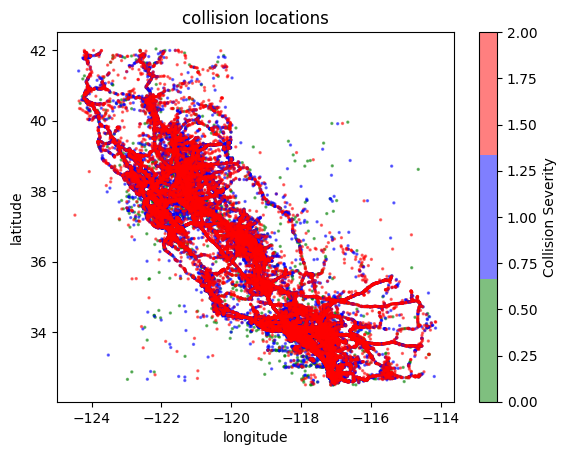

In [ ]:
from matplotlib.colors import ListedColormap
cmap_colors = ['#008000', '#0000FF', '#FF0000']
custom_cmap = ListedColormap(cmap_colors)
plt.scatter(cut_df['longitude'], cut_df['latitude'], c=cut_df['collision_severity'], cmap=custom_cmap, s=2, alpha=0.5)
plt.colorbar(label='Collision Severity')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('collision locations')
plt.show()

In [ ]:
cut_labels = pd.DataFrame(cut_df['collision_severity'])
cut_df = cut_df.drop(['collision_severity'], axis=1)

cut_labels_test = pd.DataFrame(test_df['collision_severity'])
cut_df_test = test_df.drop(['collision_severity'], axis=1)

In [ ]:
onehot_corr = cut_df.corr()['collision_severity'].drop('collision_severity')

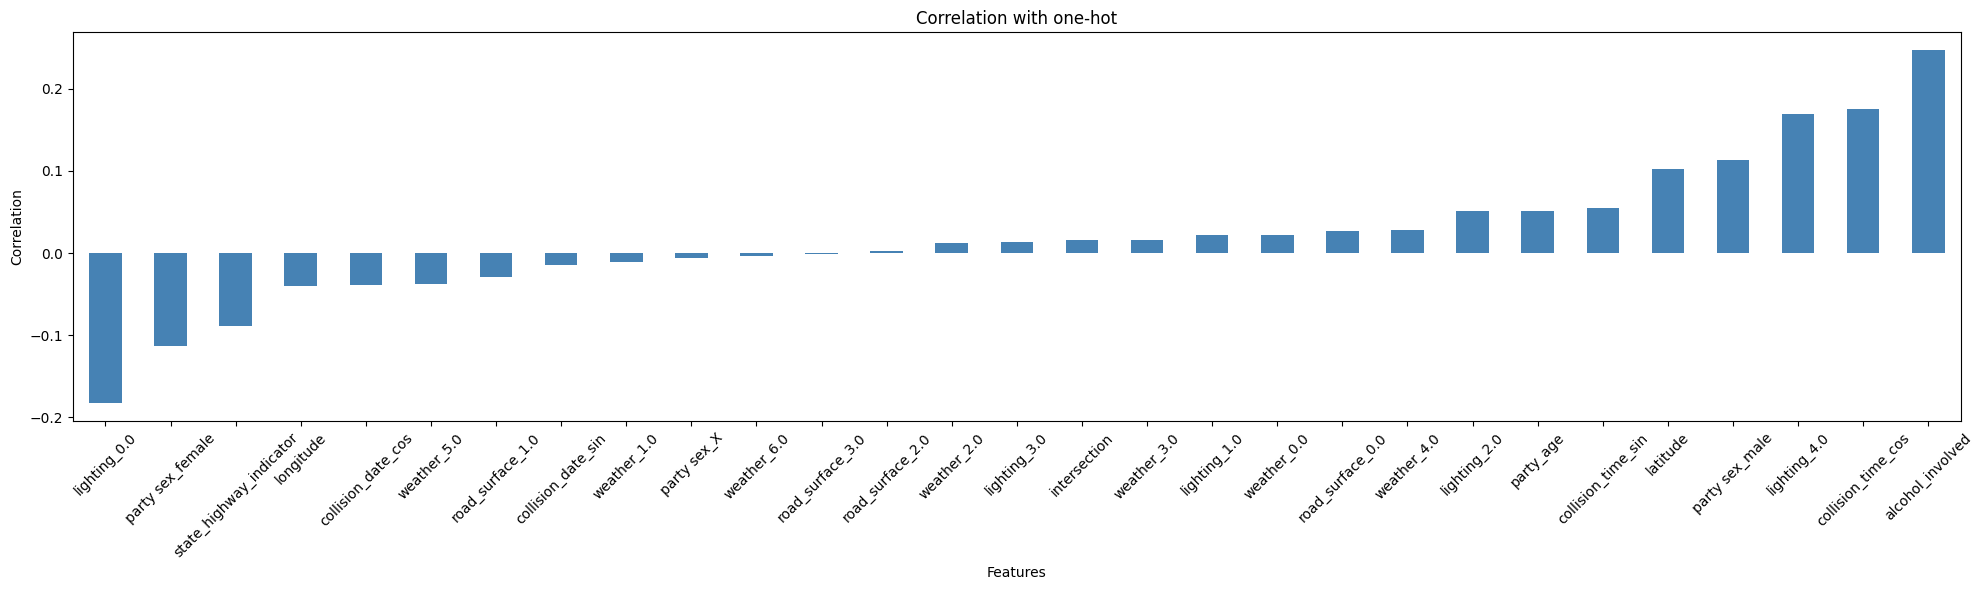

In [ ]:
plt.figure(figsize=(20, 6))
onehot_corr.sort_values().plot(kind='bar', color='steelblue')
plt.title("Correlation with one-hot")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

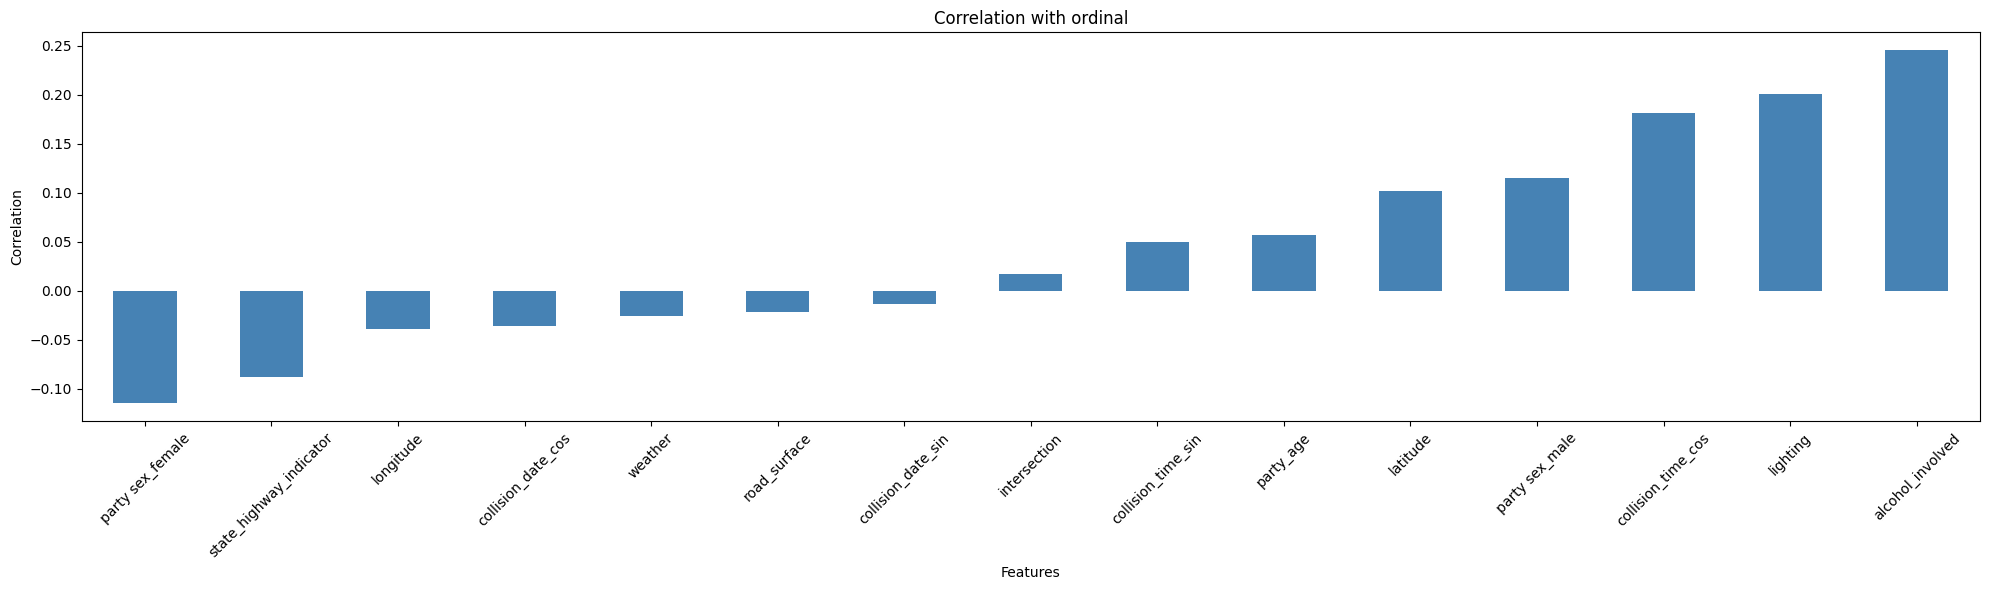

In [ ]:
ord_corr = cut_df.corr()['collision_severity'].drop('collision_severity')
plt.figure(figsize=(20, 6))
ord_corr.sort_values().plot(kind='bar', color='steelblue')
plt.title("Correlation with ordinal")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print(len(cut_labels))
print(len(cut_df))

100000
100000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = cut_df, cut_df_test, cut_labels, cut_labels_test # train_test_split(cut_df, cut_labels, test_size=0.1, random_state=41)
y_train, y_test = y_train['collision_severity'].ravel(), y_test['collision_severity'].ravel()

In [ ]:
import sklearn.tree as tree

tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

tree_preds = tree_clf.predict(X_test)
print('Decision tree acc:', (accuracy_score(y_test, tree_preds)))

Decision tree acc: 0.613696556942868


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest100_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest100_clf.fit(X_train, y_train)
forest100_preds = forest100_clf.predict(X_test)
print('Random forest (100) acc:', (accuracy_score(y_test, forest100_preds)))

Random forest (100) acc: 0.7106642884168424


In [ ]:
forest500_clf = RandomForestClassifier(n_estimators=500, random_state=42)
forest500_clf.fit(X_train, y_train)
forest500_preds = forest500_clf.predict(X_test)
print('Random forest (500) acc:', (accuracy_score(y_test, forest500_preds))) # 0.607

Random forest (500) acc: 0.7089887033133344


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_preds = gnb_clf.predict(X_test)
print('Naive bayes acc:', (accuracy_score(y_test, gnb_preds)))

Naive bayes acc: 0.7515809956218583


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test)
print('KNN acc:', (accuracy_score(y_test, knn_preds)))

KNN acc: 0.6956921247500135


In [ ]:
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC

# svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# svm_clf.fit(X_train, y_train)
# svm_preds = svm_clf.predict(X_test)
# print('SVC acc:', (accuracy_score(y_test, svm_preds)))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gradboost_clf1 = GradientBoostingClassifier(learning_rate = 0.1, random_state=41)
gradboost_clf1.fit(X_train, y_train)
gradboost_preds1 = gradboost_clf1.predict(X_test)
print('Grad boost (lr=0.1) acc:', (accuracy_score(y_test, gradboost_preds1))) # 0.67 - 64% affter 44 min of processing whole dataset

Grad boost (lr=0.1) acc: 0.2961


In [ ]:
gradboost_clf2 = GradientBoostingClassifier(learning_rate = 0.2, random_state=41)
gradboost_clf2.fit(X_train, y_train)
gradboost_preds2 = gradboost_clf2.predict(X_test)
print('Grad boost (lr=0.2) acc:', (accuracy_score(y_test, gradboost_preds2))) # 0.658

# NARROW DOWN THE GOOD COMBOS OF FEATURES ON THE OTHER MODELS AND THEN DO IT ON THE NEURAL NET (DONT EXPERIMENT FEATURES WITH NEURAL NET)


Grad boost (lr=0.2) acc: 0.5296


In [ ]:
# confusion matrix, classification report, data exploration visualizations

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label=y_train)

dtest = xgb.DMatrix(data=X_test, label=y_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',

}
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)
xgb_preds = xgb_model.predict(dtest)
print('xgboost (default hyperparams) acc:', (accuracy_score(y_test, xgb_preds)))

In [ ]:
    # from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
params = {
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'verbose': -1,

}
num_round = 100
lgb_model = lgb.train(params, train_data, num_round, valid_sets=[test_data])
lgb_preds = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
lgb_preds = np.argmax(lgb_preds, axis=1)
print('lightgbm (default hyperparams) acc:', (accuracy_score(y_test, lgb_preds)))

lightgbm (default hyperparams) acc: 0.2966666666666667


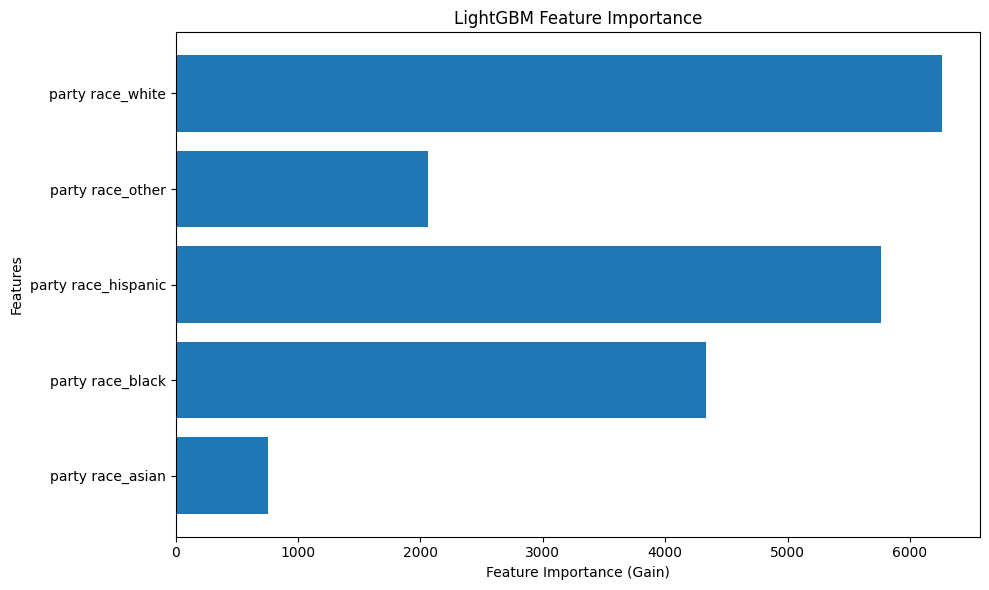

In [ ]:
feature_importance = lgb_model.feature_importance(importance_type='gain')
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importance, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print("Macro: " + str(sklearn.metrics.f1_score(y_test, lgb_preds,average='macro')))
print("Micro: " + str(sklearn.metrics.f1_score(y_test, lgb_preds,average='micro')))

Macro: 0.43673979969925647
Micro: 0.5981191595738349


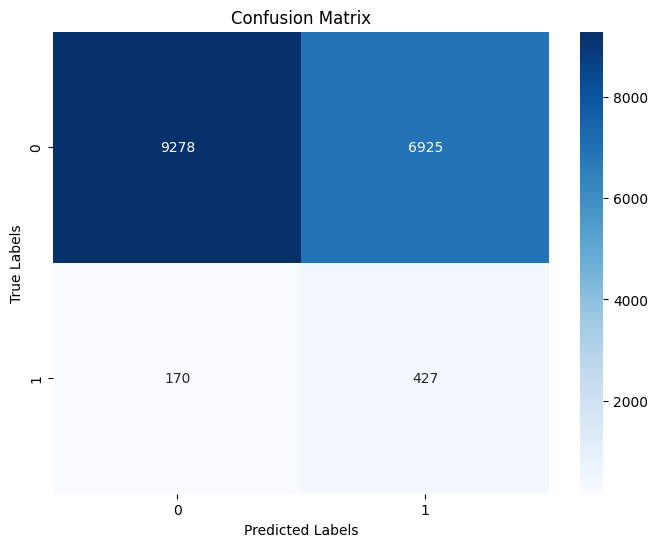

In [ ]:
# Create and display the confusion matrix
conf_matrix = confusion_matrix(y_test, lgb_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Non-Severe       0.98      0.59      0.74     16112
      Severe       0.07      0.75      0.13       689

    accuracy                           0.60     16801
   macro avg       0.53      0.67      0.43     16801
weighted avg       0.95      0.60      0.71     16801



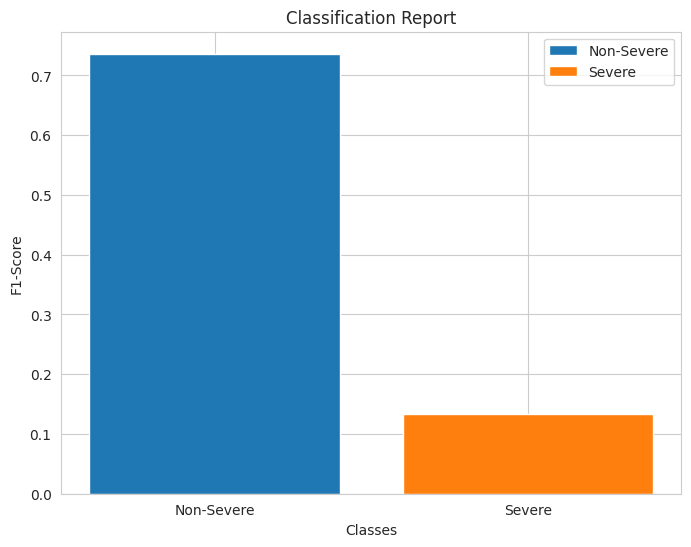

In [ ]:
lgb_preds_class = np.round(lgb_preds)

# Generate a classification report
class_names = ['Non-Severe', 'Severe']  # Replace with your class names
report = classification_report(y_test, lgb_preds_class, target_names=class_names, output_dict=True)

# Print the classification report
print(classification_report(y_test, lgb_preds_class, target_names=class_names))

# Visualize the classification report using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
for key in report.keys():
    row = report[key]
    if key in class_names:
        ax.bar(class_names.index(key), row['f1-score'], label=key)

ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_xlabel('Classes')
ax.set_ylabel('F1-Score')
ax.set_title('Classification Report')
ax.legend()
plt.show()